In [72]:
using Plots, PlotThemes, ColorSchemes
using LinearAlgebra, SparseArrays, ToeplitzMatrices
using Statistics, Distributions
using FFTW
using Trapz

theme(:juno)
default(fontfamily="times", size=(1200,400), palette=:seaborn_deep6, linewidth=2)

### Comparación de estimadores MMSE y LMMSE

Para estimar un nivel de contínua $A$ a partir de $N$ mediciones con ruido AWGN: $x[n] = A + w[n]$ con $w\sim\mathcal N(0, \sigma_w^2)$, usando una distribución a priori uniforme: $A\sim\mathcal U(-A_0, A_0)$.

#### Estimador MMSE
- Encontramos, a partir de la distribución a priori $p(A)$ y un vector de datos $\mathbf x$, la distribución a posteriori $p(A|\mathbf x)$
$$p(A|\mathbf x) = \left[
\begin{aligned} 
&\frac 1 \alpha \exp\left[-\frac{(A-\overline{\mathbf x})^2}{\frac{2\sigma_{\mathbf x}^2}{N}}\right] \quad &\text{si} \quad |A|\le A_0\\
&0 \quad &\text{si} \quad |A|>A_0 
\end{aligned} \right. \qquad\qquad \text{con}\qquad \alpha = \int_{-A_0}^{A_0}\exp\left[-\frac{(A-\overline{\mathbf x})^2}{\frac{2\sigma_{\mathbf x}^2}{N}}\right]dA
$$
- El estimador MMSE está dado por el valor esperado de la distribución a posteriori, resuelto con integral numérica `trapz`
$$ \hat A_{MMSE} = E_{A|\mathbf x}[A] = \int_{-A_0}^{A_0}p(A|\mathbf x) dA $$

#### Estimador LMMSE

- Usamos el resultado $\hat A_{LMMSE} = C_{A\mathbf x}C_{\mathbf x\mathbf x}^{-1}\mathbf x$ 
  
  - $C_{\mathbf x \mathbf x} = E[A^2] \mathbf 1 \mathbf 1^T + \sigma_{\mathbf x}^2 \mathbf I$ 
   
  - $C_{A\mathbf x} = E[A^2] \mathbf 1^T$
  
  
- Aplicando $E[A^2] = E^2[A] + Var[A]$ con $E[A] = 0$
  
  - $C_{\mathbf x \mathbf x} = \sigma_A^2 \mathbf 1 \mathbf 1^T + \sigma_{\mathbf x}^2 \mathbf I$ 
  
  - $C_{A\mathbf x} = \sigma_A^2 \mathbf 1^T$

En todos los casos se presupone desconocida la varianza del ruido para la estimación, se usa $\sigma_{\mathbf x}^2$ varianza muestral de los datos $\mathbf x$.

Se define la función `MMSE_estimation` que estima el parámetro $A$ con distribución a priori `A_dist` a partir de `N` muestras con ruido de distribución `w_dist`. 

Retorna los estimadores `A_MMSE` y `A_LMMSE` junto con el valor verdadero de `A`, además de la distribución a posteriori `pA_post` y las muestras usadas en la estimación `x`.

In [73]:
function MMSE_Estimation(A_dist, w_dist, N; A=nothing, x=[])
    A = isnothing(A) ? rand(A_dist) : A
     
    M = N-length(x)
    w = rand(w_dist, M)

    x = [x; A.+w]

    As = range(-1.5A0, 1.5A0, 500)    
    pA_post = [-A0 < A < A0 ? exp(-(A-mean(x))^2/(2*var(x)/N)) : 0 for A in As]
    pA_post = pA_post/trapz(As, pA_post)
    A_MMSE = trapz(As, As.*pA_post)

    Cxx = var(A_dist)*ones(N)*ones(N)'+var(x)*I
    Cθx = var(A_dist)*ones(N)'
    A_LMMSE = Cθx*inv(Cxx)*x

    return Dict(:A_MMSE => A_MMSE, :A_LMMSE => A_LMMSE, :As => As, :pA_post => pA_post, :pA_pri => pdf.(A_dist, As), :x => x, :A => A)
end

MMSE_Estimation (generic function with 1 method)

Para visualizar se grafica 
- Las muestras de la realización de $x[n] = A+w[n]$ sobre el eje horizontal $n$, junto con el parámetro de contínua $A$ y sus estimadores $\hat A_{MMSE}$ y $\hat A_{LMMSE}$
- Las distribuciones a priori $p(A)$ y a posteriori $p(A|\mathbf x)$ sobre el eje horizontal $A$, junto con el parámetro $A$ y sus estimadores $\hat A_{MMSE}$ y $\hat A_{LMMSE}$

In [74]:
function plot_realizacion(realiz)
    lim = maximum(abs.(extrema(realiz[:x])))*1.1
    p1 = plot(title="Realización", ylims=(-lim, lim))
    plot!(p1, [1, N], [realiz[:A], realiz[:A]], label="A")
    plot!(p1, [1, N], [realiz[:A_MMSE], realiz[:A_MMSE]], label="MMSE")
    plot!(p1, [1, N], [realiz[:A_LMMSE], realiz[:A_LMMSE]], label="LMMSE")
    plot!(p1, realiz[:x], label="x[n]", linewidth=1)
    maxP = maximum(realiz[:pA_post])*1.05
    p2 = plot(title="Probabilidad de A")
    plot!(p2, [realiz[:A], realiz[:A]], [0, maxP], label="A")
    plot!(p2, [realiz[:A_MMSE], realiz[:A_MMSE]], [0, maxP], label="MMSE")
    plot!(p2, [realiz[:A_LMMSE], realiz[:A_LMMSE]], [0, maxP], label="LMMSE")
    plot!(p2, realiz[:As], realiz[:pA_pri], label="p(A)")
    plot!(p2, realiz[:As], realiz[:pA_post], label="p(A|x)", color=:teal)
    plot(p1, p2, layout=(1,2))
end

plot_realizacion (generic function with 1 method)

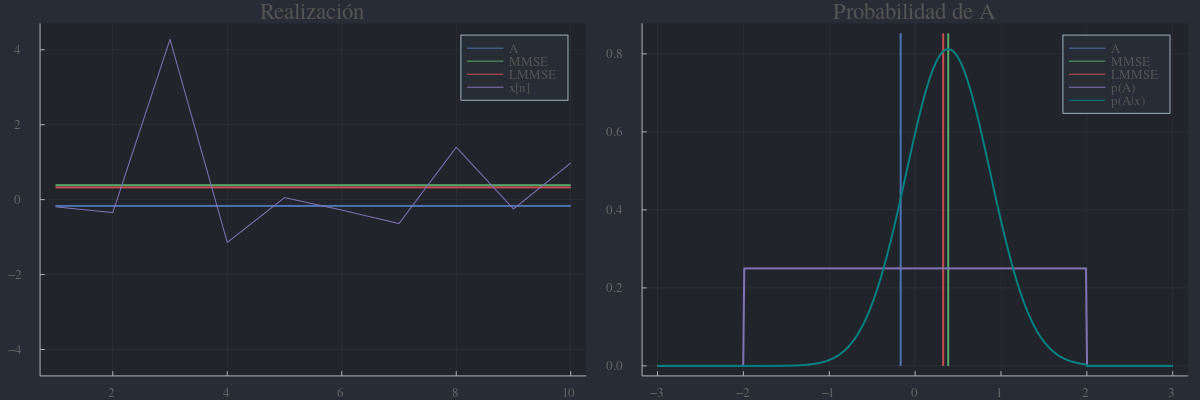

In [75]:
A0 = 2
A_dist = Uniform(-A0, A0) 
Var = 2
w_dist = Normal(0, Var)

N = 10
realiz = MMSE_Estimation(A_dist, w_dist, N)
plot_realizacion(realiz)

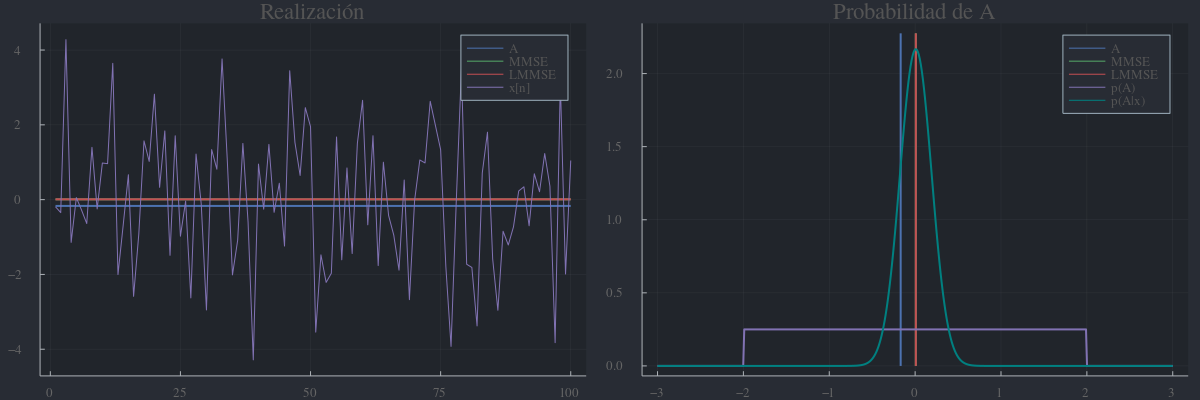

In [76]:
N = 100
realiz = MMSE_Estimation(A_dist, w_dist, N; A=realiz[:A], x=realiz[:x])
plot_realizacion(realiz)

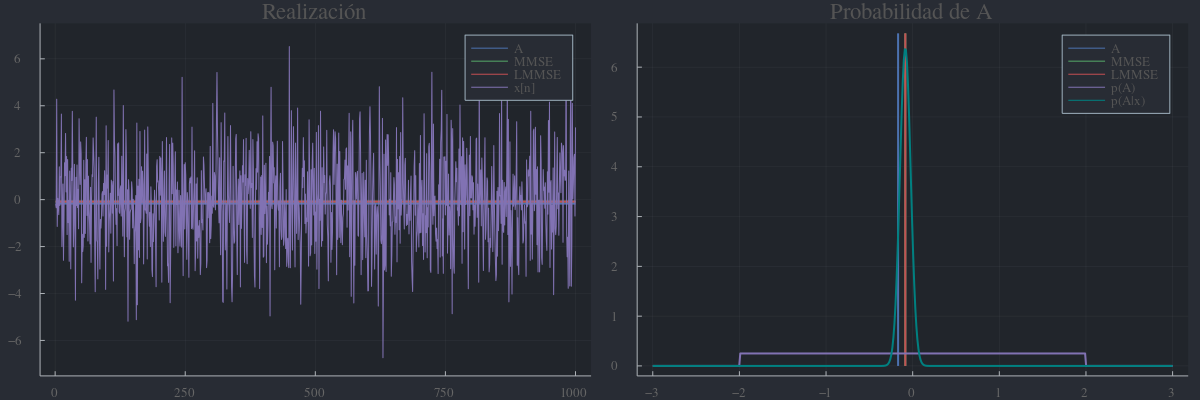

In [77]:
N = 1000
realiz = MMSE_Estimation(A_dist, w_dist, N; A=realiz[:A], x=realiz[:x])
plot_realizacion(realiz)

Para estudiar formalmente el rendimiento de los estimadores conforme incrementa $N$ se calcula el error cuadrático medio de cada uno en función de $N$, se calculan empíricamente y se compara con el resultado teórico.

Para el resultado empírico se usa la función `MSE_empirico`

- Genera $M=500$ estimaciones a partir de $N$ muestras con parámetro $A\sim p(A)$ y muestras $\mathbf x \sim p(\mathbf x)$ aleatorios e independientes
  
- Para cada realización calcula los errores cuadráticos $\varepsilon_{MMSE} = (A - \hat A_{MMSE})^2$ y $\varepsilon_{LMMSE} = (A - \hat A_{LMMSE})^2$
  
- Retorna las medias muestrales $\overline \varepsilon_{MMSE}$ y $\overline \varepsilon_{LMMSE}$  

In [78]:
function MSE_empirico(N)
    realizs = [MMSE_Estimation(A_dist, w_dist, N) for i in 1:500]
    ϵ_MMSE  = [(r[:A]-r[:A_MMSE])^2  for r in realizs] 
    ϵ_LMMSE = [(r[:A]-r[:A_LMMSE])^2 for r in realizs] 
    return [mean(ϵ_MMSE) mean(ϵ_LMMSE)]
end

MSE_empirico (generic function with 1 method)

In [80]:
function MSE_teorico(N) 

    Cxx = var(A_dist)*ones(N)*ones(N)'+var(w_dist)*I
    Cθx = var(A_dist)*ones(N)'
    LMMSE_MSE = var(A_dist) - Cθx*inv(Cxx)*Cθx'

    return(1/(N/var(w_dist)+1/var(A_dist)), LMMSE_MSE)
end

In [1]:
i = 10:50
mse_empirico, mse_teorico= MSE_empirico.(i), MSE_teorico.(i)

plot(title="Error Cuadrático Medio de estimadores MMSE y LMMSE", xlabel="N", ylabel="ECM")
plot!(i, first.(mse_empirico), color=:darkred, label="Error MMSE Empírico", ylims = [0, 0.35])
plot!(i, first.(mse_teorico), color=:darkred, style=:dash, label="Error MMSE Teórico")
plot!(i, last.(mse_empirico), color=:teal, label="Error LMMSE Empírico")
plot!(i, last.(mse_teorico), color=:teal, style=:dash, label="Error LMMSE Teórico")

UndefVarError: UndefVarError: MSE_empirico not defined